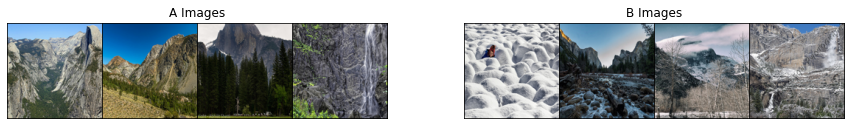

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import itertools, glob, os

from CycleGAN_pytorch import ReplayBuffer, Dataset_Cycle

batch_size = 32
img_size = 128
root = '/home/sk851/data/summer2winter_yosemite'

transform = [ transforms.Resize(int(img_size*1.12), Image.BICUBIC), transforms.RandomCrop(img_size), 
                transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(Dataset_Cycle(root, transforms_=transform), batch_size=batch_size, shuffle=True, num_workers=2)

# Show data example
real = next(iter(dataloader))
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("A Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real['A'][:4], padding=1, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("B Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real['B'][:4], padding=1, normalize=True).cpu(),(1,2,0)))
plt.show()

In [2]:
#########################
###  CycleGAN Training
#########################

from CycleGAN_pytorch import Generator, Discriminator, train, weights_init_normal

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Build generators and discriminators respectively
G_A2B = Generator(inum_c=3, onum_c=3, n_downsample_block=2, n_residual_blocks=9).to(device)
G_B2A = Generator(inum_c=3, onum_c=3, n_downsample_block=2, n_residual_blocks=9).to(device)
D_A = Discriminator(num_c=3, d_dims=[64,128,256,512]).to(device)
D_B = Discriminator(num_c=3, d_dims=[64,128,256,512]).to(device)

# Initialize weight
G_A2B.apply(weights_init_normal)
G_B2A.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Define optimizer
lr = 0.0002
optimizer_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.9)
lr_scheduler_D_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=10, gamma=0.9)
lr_scheduler_D_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=10, gamma=0.9)

train(n_epochs=50, dataloader=dataloader, G_A2B=G_A2B, G_B2A=G_B2A, D_A=D_A, D_B=D_B, 
    optimizer_G=optimizer_G, optimizer_D_A=optimizer_D_A, optimizer_D_B=optimizer_D_B, 
    lr_scheduler_G=lr_scheduler_G, lr_scheduler_D_A=lr_scheduler_D_A, lr_scheduler_D_B=lr_scheduler_D_B, cuda=cuda)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5 / loss_G:8.9754 / loss_G_identity:2.3221 / loss_G_GAN:0.7682 /  loss_G_cycle:5.8851 / loss_D:0.5484
Epoch: 10 / loss_G:6.8650 / loss_G_identity:1.8657 / loss_G_GAN:0.7721 /  loss_G_cycle:4.2272 / loss_D:0.4326
Epoch: 15 / loss_G:6.8005 / loss_G_identity:1.7262 / loss_G_GAN:0.8405 /  loss_G_cycle:4.2338 / loss_D:0.3330
Epoch: 20 / loss_G:5.7082 / loss_G_identity:1.6289 / loss_G_GAN:0.5688 /  loss_G_cycle:3.5106 / loss_D:0.3754
Epoch: 25 / loss_G:5.8704 / loss_G_identity:1.5226 / loss_G_GAN:1.1011 /  loss_G_cycle:3.2468 / loss_D:0.3742
Epoch: 30 / loss_G:5.2846 / loss_G_identity:1.4121 / loss_G_GAN:0.6706 /  loss_G_cycle:3.2018 / loss_D:0.2997
Epoch: 35 / loss_G:5.3411 / loss_G_identity:1.3034 / loss_G_GAN:1.1703 /  loss_G_cycle:2.8674 / loss_D:0.2727
Epoch: 40 / loss_G:5.4796 / loss_G_identity:1.3551 / loss_G_GAN:1.2099 /  loss_G_cycle:2.9146 / loss_D:0.2409
Epoch: 45 / loss_G:4.9121 / loss_G_identity:1.2691 / loss_G_GAN:1.0216 /  loss_G_cycle:2.6214 / loss_D:0.2805
Epoch: 50 /

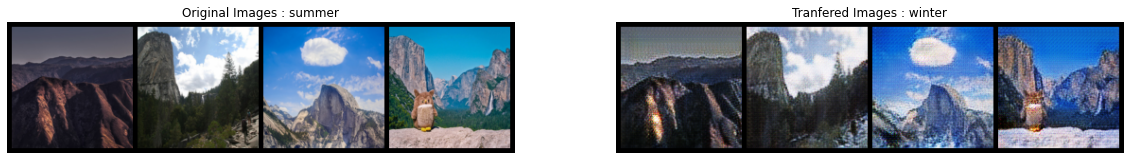

In [6]:
#########################
###  CycleGAN Testing
#########################

root = '/home/sk851/data/summer2winter_yosemite'
transform = [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
testloader = DataLoader(Dataset_Cycle(root, transforms_=transform, mode='test'), batch_size=4, shuffle=True, num_workers=2)

real = next(iter(testloader))
# Plot real images
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images : summer")
plt.imshow(np.transpose(torchvision.utils.make_grid(real['A'], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot tranfered images
G_A2B.eval()
gen_img = G_A2B(real['A'].to(device))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Tranfered Images : winter")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_img.detach().cpu(), padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()